In [1]:
#https://github.com/zclaytor/kiauhoku/blob/master/notebooks/mcmc_offsets.ipynb
import numpy as np
import matplotlib.pyplot as plt
import kiauhoku as kh
import pandas as pd

In [2]:
# data/err are [teff, L/Lsun, [M/H]]
#data = [1.24, 0.1020, -0.12] #au mic pre star lite
#err = [105, 0.0037, 0.11] #au mic pre star lite


In [2]:
# use grid points between ZAMS (201) and RGBump (605)
qstring = '0.6 <= initial_mass <= 2 and -1.0 <= initial_met <= 0.5 and 201 <= eep <= 605'

# Whether to fit evolved metallicity (True) or use the initial metallicity.
# False is probably fine if you're not on the giant branch.
evolve_met = False

# load grid, remove unwanted rows
yrec = kh.load_eep_grid("yrec").query(qstring)
# set column names to some standard
yrec['mass'] = yrec['Mass(Msun)']
yrec['teff'] = 10**yrec['Log Teff(K)']
yrec['lum'] = 10**yrec['L/Lsun']
if evolve_met:
    yrec['met'] = np.log10(yrec['Zsurf']/yrec['Xsurf']/0.0253)
else:
    yrec['met'] = yrec.index.get_level_values('initial_met')
yrec['age'] = yrec['Age(Gyr)']
# set name for readability of output
yrec.set_name('yrec')
# cast to interpolator
yrec = yrec.to_interpolator()

mist = kh.load_eep_grid("mist").query(qstring)
mist['mass'] = mist['star_mass']
mist['teff'] = 10**mist['log_Teff']
mist['lum'] = 10**mist['log_L']
if evolve_met:
    mist['met'] = mist['log_surf_z'] - np.log10(mist['surface_h1']*0.0173)
else:
    mist['met'] = mist.index.get_level_values('initial_met')
mist['logg'] = mist['log_g']
mist['age'] = mist['star_age'] / 1e9
mist.set_name('mist')
mist = mist.to_interpolator()

dart = kh.load_eep_grid("dartmouth").query(qstring)
dart['mass'] = dart.index.to_frame()['initial_mass']
dart['teff'] = 10**dart['Log T']
dart['lum'] = 10**dart['Log L']
if evolve_met:
    dart['met'] = np.log10(dart['(Z/X)_surf']/0.0229)
else:
    dart['met'] = dart.index.get_level_values('initial_met')
dart['logg'] = dart['Log g']
dart['age'] = dart['Age (yrs)'] / 1e9
dart.set_name('dart')
dart = dart.to_interpolator()

gars = kh.load_eep_grid("garstec").query(qstring)
gars['mass'] = gars['M/Msun']
gars['teff'] = gars['Teff']
gars['lum'] = 10**gars['Log L/Lsun']
if evolve_met:
    gars['met'] = np.log10(gars['Zsurf']/gars['Xsurf']/0.0245)
else:
    gars['met'] = gars.index.get_level_values('initial_met')
gars['age'] = gars['Age(Myr)'] / 1e3
gars.set_name('gars')
gars = gars.to_interpolator()

In [3]:
def fit_all_grids(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['yrec', 'mist', 'dartmouth', 'garstec'],
        [yrec, mist, dart, gars]):
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames

    return models

def compute_statistics(models, exclude=None):
    stats = models.copy()
    if exclude is not None:
        stats = stats.drop(columns=exclude)

    mean = stats.mean(axis=1)
    stdev = stats.std(axis=1, ddof=1)
    max_offset = stats.max(axis=1) - stats.min(axis=1)

    stats['mean'] = mean
    stats['stdev'] = stdev
    stats['max offset'] = max_offset

    return stats

In [242]:
def fit_yrec(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['yrec'],
        [yrec]):
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames
    models
    return models

def fit_gars(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['gars'],
        [gars]):
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames
    models
    return models

def fit_mist(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['mist'],
        [mist]):
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames
    models
    return models


def fit_dart(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['dart'],
        [dart]):
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames
    models
    return models



def yrec_iso(ages, metals):
    masses=np.linspace(0.9,1.25,500) #[.9, .95, 1.0, 1.05, 1.1, 1.15, 1.20, 1.25]
    gridnames = []
    models = []
    for i in range(len(masses)):
        star={'age':ages, 'met':metals, 'mass':masses[i] }
        model1=fit_yrec(star,scale=(0.1, 0.1, 0.1), tol=1e-6)
        models.append(model1)
        #models.columns = gridnames
    models = pd.concat(models, axis=1)
    models.columns = masses
    return models

def mist_iso(ages, metals):
    masses=np.linspace(0.9,1.25,500) #[.9, .95, 1.0, 1.05, 1.1, 1.15, 1.20, 1.25]
    gridnames = []
    models = []
    for i in range(len(masses)):
        star={'age':ages, 'met':metals, 'mass':masses[i] }
        model1=fit_mist(star,scale=(0.1, 0.1, 0.1), tol=1e-6)
        models.append(model1)
        #models.columns = gridnames
    models = pd.concat(models, axis=1)
    models.columns = masses
    return models

def dart_iso(ages, metals):
    masses=np.linspace(0.9,1.25,500) #[.9, .95, 1.0, 1.05, 1.1, 1.15, 1.20, 1.25]
    gridnames = []
    models = []
    for i in range(len(masses)):
        star={'age':ages, 'met':metals, 'mass':masses[i] }
        model1=fit_dart(star,scale=(0.1, 0.1, 0.1), tol=1e-6)
        models.append(model1)
        #models.columns = gridnames
    models = pd.concat(models, axis=1)
    models.columns = masses
    return models

def gars_iso(ages, metals):
    masses=np.linspace(0.9,1.25,500) #[.9, .95, 1.0, 1.05, 1.1, 1.15, 1.20, 1.25]
    gridnames = []
    models = []
    for i in range(len(masses)):
        star={'age':ages, 'met':metals, 'mass':masses[i] }
        model1=fit_gars(star,scale=(0.1, 0.1, 0.1), tol=1e-6)
        models.append(model1)
        #models.columns = gridnames
    models = pd.concat(models, axis=1)
    models.columns = masses
    return models

In [8]:
aiphe2 = {'lum': 5.207, 'mass':1.2438, 'teff':5095}
models = fit_all_grids(aiphe2, scale=(0.1, 0.1, 10), tol=1e-6)
models

Fitting star with yrec...
yrec: success!
Fitting star with mist...
mist: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,mist,dartmouth,garstec
initial_mass,1.243798,1.244607,1.243801,1.247042
initial_met,-0.111522,-0.099345,-0.120512,-0.079159
eep,542.609874,476.280961,544.872339,546.419488
mass,1.243798,1.243801,1.243801,1.243799
teff,5094.999685,5095.001519,5094.999912,5095.000852
lum,5.207001,5.207012,5.207001,5.207000
met,-0.111522,-0.099345,-0.120512,-0.079159
logg,3.607521,3.605668,3.605367,3.600833
age,4.948986,4.539736,4.694337,4.956760


In [239]:
aiphe1= {'age': 4.948986, 'met':-0.111522}
modelY = yrec_iso(4.948986,-0.111522)



Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star wit

yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
F

yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
Fitting star with yrec...
yrec: success!
F

In [245]:
modelsG = gars_iso(4.956760,-0.079159)

Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star wit

gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
F

gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
Fitting star with gars...
gars: success!
F

In [246]:
modelsM = mist_iso(4.539736,-0.099345)

Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star wit

mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
F

mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
Fitting star with mist...
mist: success!
F

In [247]:
modelsD = dart_iso(4.694337,-0.120512)

Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star wit

dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
F

dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
Fitting star with dart...
dart: success!
F

In [139]:
modelsY

,0.900000,0.903535,0.907071,0.910606,0.914141,0.917677,0.921212,0.924747,0.928283,0.931818,...,1.218182,1.221717,1.225253,1.228788,1.232323,1.235859,1.239394,1.242929,1.246465,1.250000
initial_mass,0.900000,0.903535,0.907071,0.910606,0.914141,0.917677,0.921212,0.924747,0.928283,0.931818,...,1.218182,1.221717,1.225253,1.228788,1.232323,1.235859,1.239394,1.242929,1.246465,1.250000
initial_met,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,...,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522
eep,286.741237,288.048445,289.389101,290.762913,292.172348,293.618333,295.101656,296.623413,298.185027,299.789460,...,474.246627,480.485704,488.468799,499.304119,513.580462,526.930619,535.639550,541.410115,546.107588,550.803882
mass,0.900000,0.903535,0.907071,0.910606,0.914141,0.917677,0.921212,0.924747,0.928283,0.931818,...,1.218182,1.221717,1.225253,1.228788,1.232323,1.235859,1.239394,1.242929,1.246465,1.250000
teff,5583.327372,5597.388296,5611.452987,5625.519763,5639.588297,5653.661324,5667.734172,5681.807100,5695.880971,5709.956144,...,5985.725444,5900.455573,5791.257158,5644.150303,5453.970582,5280.758097,5172.174132,5107.080226,5063.380494,5028.220878
lum,0.647217,0.663974,0.680886,0.697957,0.715195,0.732612,0.750213,0.768009,0.786013,0.804230,...,5.181535,5.178222,5.097691,4.884912,4.536217,4.359141,4.556262,5.046637,5.808464,6.940713
met,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,...,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522,-0.111522
logg,4.530927,4.527871,4.524779,4.521651,4.518485,4.515279,4.512032,4.508740,4.505402,4.502016,...,3.885531,3.863152,3.839856,3.815668,3.788582,3.748373,3.692150,3.625307,3.549034,3.459791
age,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,...,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986,4.948986


In [249]:
teffsY = np.array(modelY.loc["teff"])
lumsY = np.array(modelY.loc["lum"])  
massY = np.array(modelY.loc["mass"])
# checking data type of rows
#print(teffs, lums)

In [250]:
teffsG = np.array(modelsG.loc["teff"])
lumsG = np.array(modelsG.loc["lum"])  
massG = np.array(modelsG.loc["mass"])

In [251]:
teffsM = np.array(modelsM.loc["teff"])
lumsM = np.array(modelsM.loc["lum"])  
massM = np.array(modelsM.loc["mass"])

In [252]:
teffsD = np.array(modelsD.loc["teff"])
lumsD = np.array(modelsD.loc["lum"])  
massD = np.array(modelsD.loc["mass"])

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

In [253]:
aiphe1m=1.1938
close=np.where(massY > aiphe1m)
lumaiphe1Y=lumsY[np.array(close)[0,0]]
teffaiphe1Y=teffsY[np.array(close)[0,0]]
print( lumaiphe1Y, teffaiphe1Y, massY[np.array(close)[0,0]] )

close=np.where(massG > aiphe1m)
lumaiphe1G=lumsG[np.array(close)[0,0]]
teffaiphe1G=teffsG[np.array(close)[0,0]]
print( lumaiphe1G, teffaiphe1G, massG[np.array(close)[0,0]] )

close=np.where(massG > aiphe1m)
lumaiphe1D=lumsD[np.array(close)[0,0]]
teffaiphe1D=teffsD[np.array(close)[0,0]]
print( lumaiphe1D, teffaiphe1D, massD[np.array(close)[0,0]] )

close=np.where(massM > aiphe1m)
lumaiphe1M=lumsM[np.array(close)[0,0]]
teffaiphe1M=teffsM[np.array(close)[0,0]]
print( lumaiphe1M, teffaiphe1M, massM[np.array(close)[0,0]] )

3.5925462528405943 6157.785233903974 1.1938878479488895
4.255166471952972 6107.245494006721 1.193887703091538
4.316176815073831 6271.418512127546 1.1938877239143482
4.708766622043588 6275.76398391504 1.1938878028068376


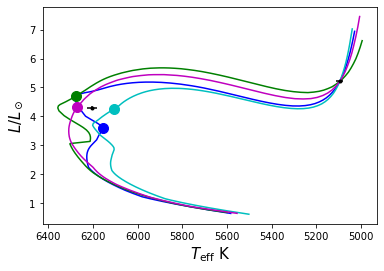

In [258]:
tsun=5777.
aipheteff=[1.074*tsun,0.882*tsun]
aiphetefferr=[0.004*tsun,0.003*tsun]
aiphelum=[4.29, 5.207]
aiphelumerr=[0.0627, 0.065]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(teffsY,lumsY, '-b')
ax.plot([teffaiphe1Y],[lumaiphe1Y],'ob', markersize='10')
ax.plot(teffsG,lumsG, '-c')
ax.plot([teffaiphe1G],[lumaiphe1G],'oc', markersize='10')
ax.plot(teffsM,lumsM, '-g')
ax.plot([teffaiphe1M],[lumaiphe1M],'og', markersize='10')
ax.plot(teffsD,lumsD, '-m')
ax.plot([teffaiphe1D],[lumaiphe1D],'om', markersize='10')
ax.errorbar(aipheteff, aiphelum, xerr=aiphetefferr, yerr=aiphelumerr, fmt='k.')# xerr=0.004*tsun, yerr=0.0627 )
#0.882*tsun,  0.003*tsun  0.065
ax.set_xlabel(r"$T_\mathrm{eff}$ K", fontsize=15)
ax.set_ylabel(r"$L$/$L_\odot$", fontsize=15)
ax.invert_xaxis()
fig.savefig('AIPhetest.png')